# Hopping leg

Simulation model of a 2R mechanism that interacts with environment. The mechanism can be considered as robotic leg. The script show how we can use MuJoCo to conduct a virtual experiment, adjust controller, and create some plot to examine behavior and performance of a designed robot.

In [1]:
from os import path
import mujoco
import mujoco_viewer
import numpy as np
from matplotlib import pyplot as plt

- To control the robotic leg here we are going to use a simple PD controller. 

In [2]:
def controller(mjmodel: mujoco._structs.MjModel,
               mjdata: mujoco._structs.MjData,
               ref:np.array, i: int) -> None:
    """ Simple PD controller

    Args:
        mjmodel: mujoco._structs.MjModel
        mjdata: mujoco._structs.MjData
        ref (np.array): numpy array with q and dq
        i (int): iteration step
    """
    KP = 200
    KD = 5

    for k in range(2):
        error_q  = ref[0][k][i] - mjdata.qpos[k+1] # k+1 since slider joint is passive
        error_dq = ref[1][k][i] - mjdata.qvel[k+1]
        mjdata.ctrl[k] = KP * error_q + KD * error_dq

- Here I use `mj_forward` to set initial angular position. 
- Make sure you have the same timestep in the code and in the XML model.

In [3]:
SIMEND = 10
TIMESTEP = 0.0005
STEP_NUM = int(SIMEND/TIMESTEP)
MODEL_NAME = 'closed_chain_leg_scene.xml'

ROOT = path.abspath('')
FOLDER_PATH = path.join(ROOT, '')
MODEL_PATH = path.join(FOLDER_PATH, MODEL_NAME)

model = mujoco.MjModel.from_xml_path(MODEL_PATH)
data = mujoco.MjData(model)

# set initial angles
data.qpos[1] = -0.79
data.qpos[2] = -1.57
mujoco.mj_forward(model, data)

Set reference and empty lists for measurements.

In [4]:
time = np.linspace(0, SIMEND, STEP_NUM)
freq = 2*np.pi*1
q_ref  = np.array([np.pi/12 * np.sin(freq * time) - np.pi/4,
                   -np.pi/6 * np.sin(freq * time) - np.pi/2])
dq_ref = np.array([np.pi/12 * freq * np.cos(freq * time), 
                   -np.pi/6 * freq * np.cos(freq * time)])
ref = np.array([q_ref, dq_ref])

xz_ee_list = [[], []]
q_list = [[], []]
dq_list = [[], []]
tau_list = [[], []]
q_passive = [[]]

Conduct the simulation

In [5]:
viewer = mujoco_viewer.MujocoViewer(model, data,
                                    title = "open_chain_leg",
                                    width = 1920,
                                    height = 1080)

for i in range(STEP_NUM):
    if viewer.is_alive:

        tip = data.site_xpos[0]

        xz_ee_list[0].append(tip[0])
        xz_ee_list[1].append(tip[2])

        q1 = float(data.joint('hip').qpos)
        q2 = float(data.joint('joint_knee_lever').qpos)

        q_knee = float(data.joint('knee').qpos)

        dq_1 = float(data.joint('hip').qvel)
        dq_2 = float(data.joint('joint_knee_lever').qvel)

        t1 = float(data.sensor("act_torque_hip").data[0])
        t2 = float(data.sensor("act_torque_knee").data[0])

        q_list[0].append(q1)
        q_list[1].append(q2)

        q_passive[0].append(q_knee)

        dq_list[0].append(dq_1)
        dq_list[1].append(dq_2)

        tau_list[0].append(t1)
        tau_list[1].append(t2)
        
        mujoco.set_mjcb_control(controller(model, data, ref, i))
        mujoco.mj_step(model, data)
        
        viewer.render()
    
    else:
        break

viewer.close()

/tmp/ipykernel_307639/3094158900.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q1 = float(data.joint('hip').qpos)
/tmp/ipykernel_307639/3094158900.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q2 = float(data.joint('joint_knee_lever').qpos)
/tmp/ipykernel_307639/3094158900.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q_knee = float(data.joint('knee').qpos)
/tmp/ipykernel_307639/3094158900.py:19: DeprecationWarning: Conversion of an array with 

Create plots and make some conclusion 

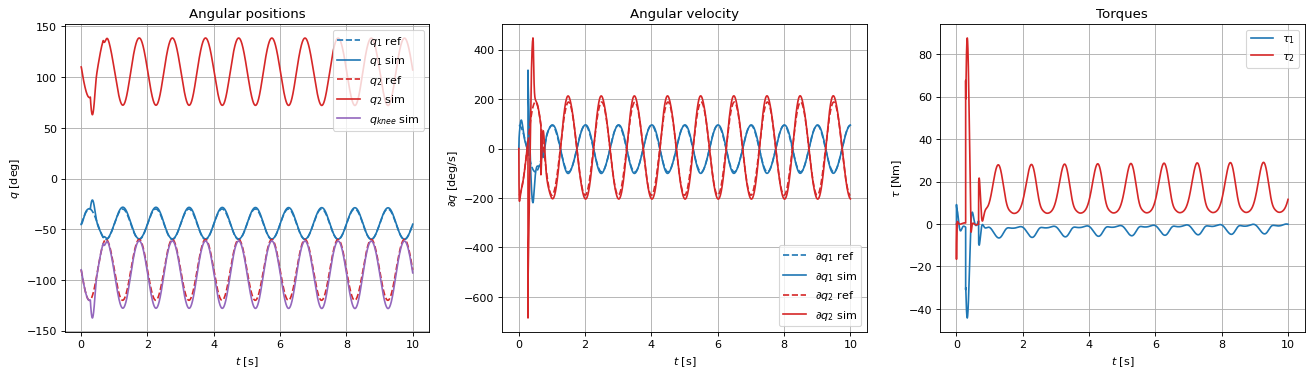

In [13]:
time_sim = np.linspace(0, SIMEND, len(q_list[0]))

plt.figure(figsize=(20, 5), dpi=80)
ang_pos = plt.subplot(131)
ang_pos.set_title("Angular positions")
ang_pos.plot(time, np.rad2deg(ref[0][0]), linestyle='--',
                color='tab:blue', label='$q_1$ ref')
ang_pos.plot(time_sim, np.rad2deg(q_list[0]),
                color='tab:blue', label='$q_1$ sim')
ang_pos.plot(time, np.rad2deg(ref[0][1]), linestyle='--',
                color='tab:red', label='$q_2$ ref')
ang_pos.plot(time_sim, np.rad2deg(q_list[1]),
                color='tab:red', label='$q_2$ sim')

ang_pos.plot(time_sim, np.rad2deg(q_passive[0]),
                color='tab:purple', label='$q_{knee}$ sim')
ang_pos.set_ylabel("$q$ [deg]")
ang_pos.set_xlabel("$t$ [s]")
ang_pos.grid(axis='both')
ang_pos.legend()

ang_vel = plt.subplot(132, sharex=ang_pos)
ang_vel.set_title("Angular velocity")
ang_vel.plot(time, np.rad2deg(ref[1][0]), linestyle='--',
                color='tab:blue', label='$\partial q_1$ ref')
ang_vel.plot(time_sim,
                np.rad2deg(dq_list[0]), color='tab:blue', label='$\partial q_1$ sim')
ang_vel.plot(time, np.rad2deg(ref[1][1]), linestyle='--',
                color='tab:red', label='$\partial q_2$ ref')
ang_vel.plot(time_sim,
                np.rad2deg(dq_list[1]), color='tab:red', label='$\partial q_2$ sim')
ang_vel.set_ylabel("$\partial q$ [deg/s]")
ang_vel.set_xlabel("$t$ [s]")
ang_vel.grid(axis='both')
ang_vel.legend()

ang_tau = plt.subplot(133, sharex=ang_vel)
ang_tau.set_title("Torques")
ang_tau.plot(time_sim, tau_list[0],
                label='$\\tau_1$', color='tab:blue')
ang_tau.plot(time_sim, tau_list[1],
                label='$\\tau_2$', color='tab:red')
ang_tau.set_ylabel("$\\tau$ [Nm]")
ang_tau.set_xlabel("$t$ [s]")
ang_tau.grid(axis='both')
ang_tau.legend()

(-137.41427380927257, -61.45486513244787)

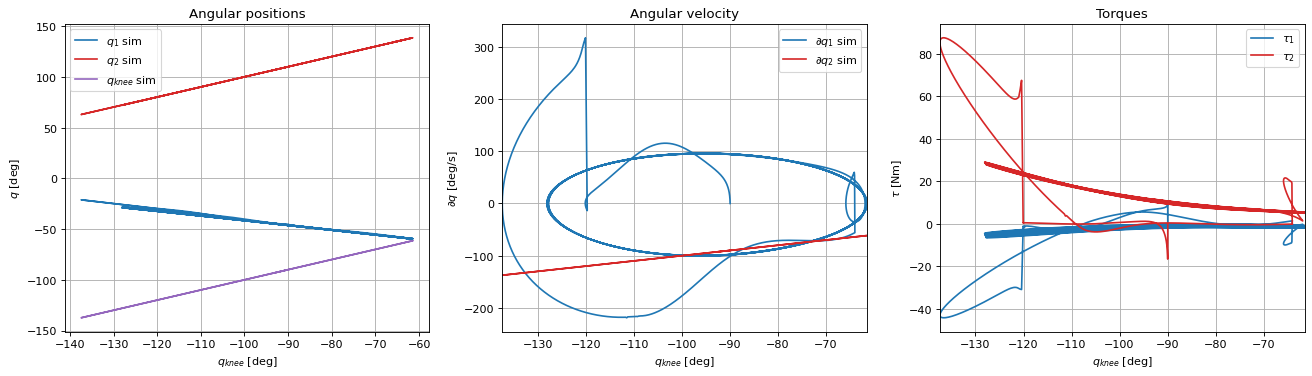

In [14]:
plt.figure(figsize=(20, 5), dpi=80)
ang_pos_rel = plt.subplot(131)
ang_pos_rel.set_title("Angular positions")
ang_pos_rel.plot(np.rad2deg(q_passive[0]), np.rad2deg(q_list[0]),
                    color='tab:blue', label='$q_1$ sim')
ang_pos_rel.plot(np.rad2deg(q_passive[0]), np.rad2deg(q_list[1]),
                    color='tab:red', label='$q_2$ sim')
ang_pos_rel.plot(np.rad2deg(q_passive[0]), np.rad2deg(q_passive[0]),
                    color='tab:purple', label='$q_{knee}$ sim')
ang_pos_rel.set_ylabel("$q$ [deg]")
ang_pos_rel.set_xlabel("$q_{knee}$ [deg]")
ang_pos_rel.grid(axis='both')
ang_pos_rel.legend()

ang_vel_rel = plt.subplot(132, sharex=ang_pos)
ang_vel_rel.set_title("Angular velocity")
ang_vel_rel.plot(np.rad2deg(q_passive[0]),
                    np.rad2deg(dq_list[0]), color='tab:blue', label='$\partial q_1$ sim')
ang_vel_rel.plot(np.rad2deg(q_passive[0]),
                    np.rad2deg(q_passive[0]), color='tab:red', label='$\partial q_2$ sim')
ang_vel_rel.set_ylabel("$\partial q$ [deg/s]")
ang_vel_rel.set_xlabel("$q_{knee}$ [deg]")
ang_vel_rel.grid(axis='both')
ang_vel_rel.legend()
ang_vel_rel.set_xlim(
    [min(np.rad2deg(q_passive[0])), max(np.rad2deg(q_passive[0]))])

ang_tau_rel = plt.subplot(133, sharex=ang_vel)
ang_tau_rel.set_title("Torques")
ang_tau_rel.plot(np.rad2deg(q_passive[0]), tau_list[0],
                    label='$\\tau_1$', color='tab:blue')
ang_tau_rel.plot(np.rad2deg(q_passive[0]), tau_list[1],
                    label='$\\tau_2$', color='tab:red')
ang_tau_rel.set_ylabel("$\\tau$ [Nm]")
ang_tau_rel.set_xlabel("$q_{knee}$ [deg]")
ang_tau_rel.grid(axis='both')
ang_tau_rel.legend()
ang_tau_rel.set_xlim([min(np.rad2deg(q_passive[0])), max(np.rad2deg(q_passive[0]))])